In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import regex as re
from sklearn.svm import SVC
from wordcloud import WordCloud, ImageColorGenerator

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Import data

In [35]:
train = pd.read_csv("/SMS_test.csv", encoding='cp1252')
test = pd.read_csv("/SMS_train.csv",encoding='cp1252')

train.head()

,S. No.,Message_body,Label
0,1,"UpgrdCentre Orange customer, you may now claim...",Spam
1,2,"Loan for any purpose £500 - £75,000. Homeowner...",Spam
2,3,Congrats! Nokia 3650 video camera phone is you...,Spam
3,4,URGENT! Your Mobile number has been awarded wi...,Spam
4,5,Someone has contacted our dating service and e...,Spam


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        125 non-null    int64 
 1   Message_body  125 non-null    object
 2   Label         125 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


Preprocessing

In [38]:
def tokenize(x):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(x)

def stemmer(x):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in x])

def lemmatize(x):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in x])

stop_words = stopwords.words('english')

#  Preprocess train dataset
# remove special characters from text column
train.Message_body = train.Message_body.str.replace('[#,@,&]', '')
# Remove digits
train.Message_body = train.Message_body.str.replace(' \d+ ','')
#Remove www
train.Message_body = train.Message_body.str.replace('w{3}','')
# remove urls
train.Message_body = train.Message_body.str.replace("http\S+", "")
# remove multiple spaces with single space
train.Message_body = train.Message_body.str.replace('\s+', ' ')
#remove all single characters
train.Message_body = train.Message_body.str.replace(r'\s+[a-zA-Z]\s+', '')
train['tokens'] = train['Message_body'].map(tokenize)
train['lemma'] = train['tokens'].map(lemmatize)
train['stems'] = train['tokens'].map(stemmer)

#  Preprocess test dataset
# remove special characters from text column
test.Message_body = test.Message_body.str.replace('[#,@,&]', '')
#Remove digits
test.Message_body = test.Message_body.str.replace(' \d+ ','')
#Remove www
test.Message_body = test.Message_body.str.replace('w{3}','')
# remove urls
test.Message_body = test.Message_body.str.replace("http\S+", "")
# remove multiple spaces with single space
test.Message_body = test.Message_body.str.replace('\s+', ' ')
#remove all single characters
test.Message_body = test.Message_body.str.replace(r'\s+[a-zA-Z]\s+', '')
test['tokens'] = test['Message_body'].map(tokenize)
test['lemma'] = test['tokens'].map(lemmatize)
test['stems'] = test['tokens'].map(stemmer)

In [39]:
train

,S. No.,Message_body,Label,tokens,lemma,stems
0,1,"UpgrdCentre Orange customer, you may now claim...",Spam,"[UpgrdCentre, Orange, customer, you, may, now,...",UpgrdCentre Orange customer you may now claim ...,upgrdcentr orang custom you may now claim your...
1,2,"Loan for any purpose £500 - £75,000. Homeowner...",Spam,"[Loan, for, any, purpose, 500, 75, 000, Homeow...",Loan for any purpose 500 75 000 Homeowners Ten...,loan for ani purpos 500 75 000 homeown tenant ...
2,3,Congrats! Nokia 3650 video camera phone is you...,Spam,"[Congrats, Nokia, 3650, video, camera, phone, ...",Congrats Nokia 3650 video camera phone is your...,congrat nokia 3650 video camera phone is your ...
3,4,URGENT! Your Mobile number has been awarded wi...,Spam,"[URGENT, Your, Mobile, number, has, been, awar...",URGENT Your Mobile number ha been awarded with...,urgent your mobil number ha been award with a ...
4,5,Someone has contacted our dating service and e...,Spam,"[Someone, has, contacted, our, dating, service...",Someone ha contacted our dating service and en...,someon ha contact our date servic and enter yo...
...,...,...,...,...,...,...
120,121,7 wonders in My WORLD 7th You 6th Ur style 5th...,Non-Spam,"[7, wonders, in, My, WORLD, 7th, You, 6th, Ur,...",7 wonder in My WORLD 7th You 6th Ur style 5th ...,7 wonder in my world 7th you 6th ur style 5th ...
121,122,Try to do something dear. You read something f...,Non-Spam,"[Try, to, do, something, dear, You, read, some...",Try to do something dear You read something fo...,tri to do someth dear you read someth for exam
122,123,Sun ah... Thk mayb can if dun have anythin on....,Non-Spam,"[Sun, ah, Thk, mayb, can, if, dun, have, anyth...",Sun ah Thk mayb can if dun have anythin on Thk...,sun ah thk mayb can if dun have anythin on thk...
123,124,"SYMPTOMS when U are in love: ""1.U like listeni...",Non-Spam,"[SYMPTOMS, when, U, are, in, love, 1, U, like,...",SYMPTOMS when U are in love 1 U like listening...,symptom when u are in love 1 u like listen son...


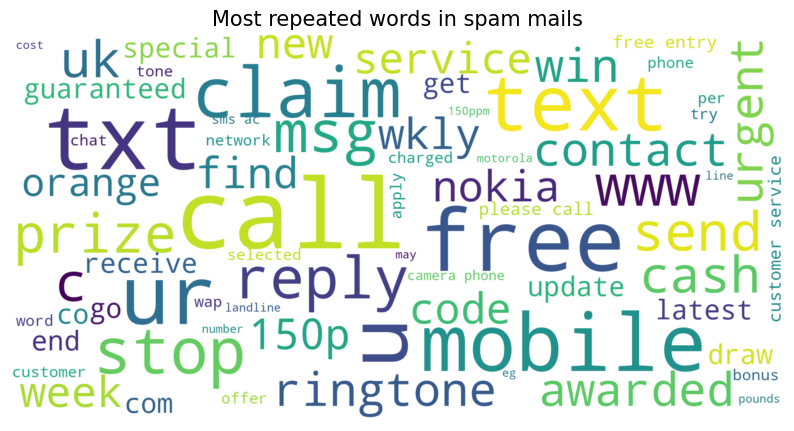

In [41]:
# WordCloud for spam marked emails in train set

# Get a string of e-mails
message_body_spam = ",".join(spam_mail.lower() for spam_mail in train.Message_body[train.Label == 'Spam'])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=70,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_spam)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in spam mails',fontsize=15)
plt.show()

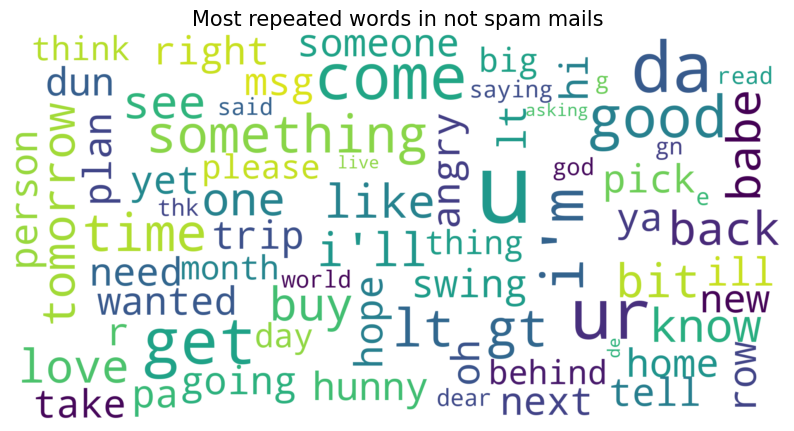

In [42]:
# WordCloud for Non-spam marked emails in train set

# Get a string of e-mails
message_body_spam = ",".join(spam_mail.lower() for spam_mail in train.Message_body[train.Label == 'Non-Spam'])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=70,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(message_body_spam)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in not spam mails',fontsize=15)
plt.show()

In [43]:
data_labels = train['Label']
data_tweets = train['stems']

train_X, test_X, train_y, test_y = train_test_split(data_tweets,
                                                    data_labels,
                                                    test_size=0.2,
                                                    random_state = 42)

val_y = test['Label']
val_X = test['stems']

Naive Bayes Pipeline

In [47]:
pipe_mnnb = Pipeline(steps = [('tf', TfidfVectorizer()), ('mnnb', MultinomialNB())])

# Create Parameter Grid
pgrid_mnnb = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__stop_words' : ['english', None],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'mnnb__alpha' : [0.1, 0.5, 1]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_mnnb = GridSearchCV(pipe_mnnb, pgrid_mnnb, cv=5, n_jobs=-1, verbose=2)

# Fit the model
gs_mnnb.fit(train_X, train_y)

# Save pipeline
joblib_file = '/content/drive/MyDrive/Models/mnnb_pipeline.pkl'
joblib.dump(gs_mnnb, joblib_file)
print(f'Pipeline enregistré sous {joblib_file}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Pipeline enregistré sous /content/drive/MyDrive/Models/mnnb_pipeline.pkl


In [65]:
# Extract best vectorizer and model
best_vectorizer = gs_mnnb.best_estimator_.named_steps['tf']
best_model = gs_mnnb.best_estimator_.named_steps['mnnb']

# Save vectorize
joblib.dump(best_vectorizer, '/content/drive/MyDrive/Models/tfidf_vectorizer_mnnb.pkl')

# Save model
joblib.dump(best_model, '/content/drive/MyDrive/Models/mnnb_model.pkl')

['/content/drive/MyDrive/Models/mnnb_model.pkl']

In [48]:
# Check the best parameters for our model
gs_mnnb.best_params_

{'mnnb__alpha': 0.1,
 'tf__max_features': 3000,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': None,
 'tf__use_idf': True}

In [49]:
print('Score of train set', gs_mnnb.score(train_X, train_y))
print('Score of test set',gs_mnnb.score(test_X, test_y))

Score of train set 1.0
Score of test set 0.92


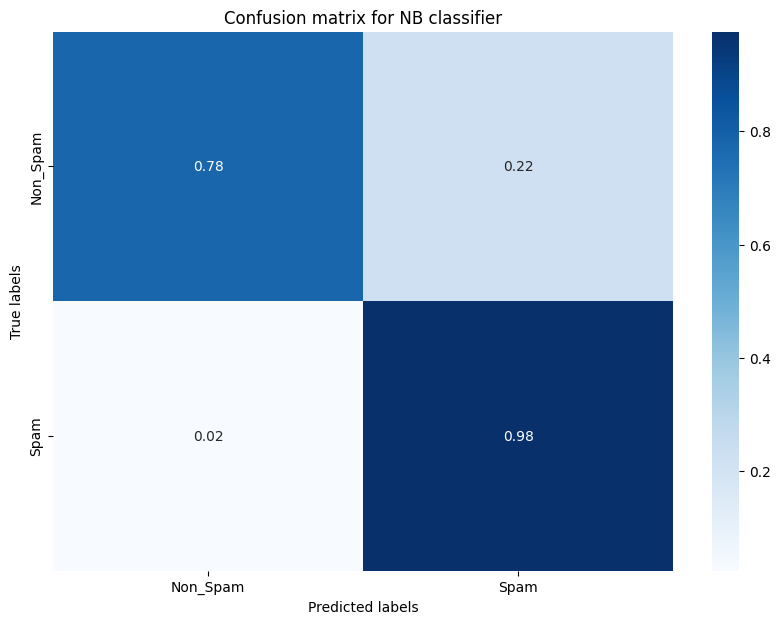

In [50]:
## Naive Bayes Predictions on val set and confusion matrix
preds_mnnb = gs_mnnb.predict(val_X)
test['preds'] = preds_mnnb

cm = confusion_matrix(test['Label'], test['preds'], normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Non_Spam','Spam'], yticklabels=['Non_Spam','Spam'])

plt.title('Confusion matrix for NB classifier')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Logistic Regression

In [52]:
pipe_lgrg = Pipeline(steps = [('tf', TfidfVectorizer()), ('lgrg', LogisticRegression())])

# Create Parameter Grid
pgrid_lgrg = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced', None],
 'lgrg__C' : [1.0, 0.9]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_lgrg = GridSearchCV(pipe_lgrg, pgrid_lgrg, cv=5, n_jobs=-1, verbose=2)

# Fit the model
gs_lgrg.fit(train_X, train_y)

# Save pipeline
joblib_file = '/content/drive/MyDrive/Models/logistic_regression_pipeline.pkl'
joblib.dump(gs_lgrg, joblib_file)
print(f'Pipeline enregistré sous {joblib_file}')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Pipeline enregistré sous /content/drive/MyDrive/Models/logistic_regression_pipeline.pkl


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual

In [64]:
# Extract best vectorizer and model
best_vectorizer = gs_lgrg.best_estimator_.named_steps['tf']
best_model = gs_lgrg.best_estimator_.named_steps['lgrg']

# Save vectorizer
joblib.dump(best_vectorizer, '/content/drive/MyDrive/Models/tfidf_vectorizer_lgrg.pkl')

# Save model
joblib.dump(best_model, '/content/drive/MyDrive/Models/lgrg_model.pkl')

['/content/drive/MyDrive/Models/lgrg_model.pkl']

In [53]:
gs_lgrg.best_params_

{'lgrg__C': 1.0,
 'lgrg__class_weight': 'balanced',
 'lgrg__penalty': 'l2',
 'tf__max_features': 1000,
 'tf__ngram_range': (1, 1),
 'tf__use_idf': False}

In [54]:
print('Score of train set', gs_lgrg.score(train_X, train_y))
print('Score of test set',gs_lgrg.score(test_X, test_y))

Score of train set 0.99
Score of test set 0.96


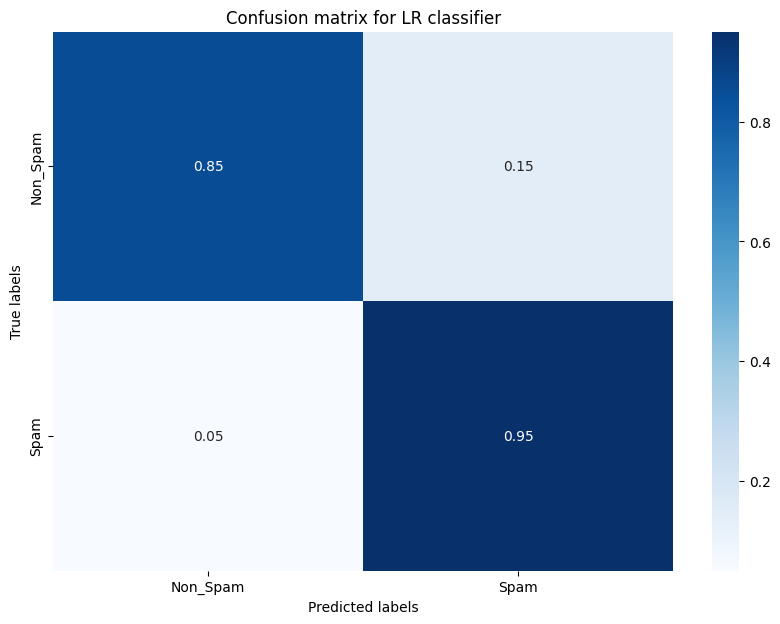

In [55]:
## LR Predictions on val set and confusion matrix
preds_lgrg = gs_lgrg.predict(val_X)
test['preds'] = preds_lgrg



# Generate confusion matrix
matrix_lr = confusion_matrix(test['Label'], test['preds'], normalize='true')

plt.figure(figsize=(10, 7))
sns.heatmap(matrix_lr, annot=True, fmt=".2f", cmap='Blues',xticklabels=['Non_Spam','Spam'], yticklabels=['Non_Spam','Spam'])
plt.title('Confusion matrix for LR classifier')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

SVC


In [61]:
pipe_svc = Pipeline(steps = [('tf', TfidfVectorizer()), ('svc', SVC())])

# Create Parameter Grid
pgrid_svc = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
 'svc__decision_function_shape' : ['ovo', 'ovr'],
 'svc__C' : [1.0, 0.9, 0.8, 0.7]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_svc = GridSearchCV(pipe_svc, pgrid_svc, cv=5, n_jobs=-1, verbose=2)

# Fit the model
gs_svc.fit(train_X, train_y)

# Save pipeline
joblib_file = '/content/drive/MyDrive/Models/svc_pipeline.pkl'
joblib.dump(gs_svc, joblib_file)
print(f'Pipeline enregistré sous {joblib_file}')

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Pipeline enregistré sous /content/drive/MyDrive/Models/svc_pipeline.pkl


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 186, in fit
    raise TypeError("Sparse precomputed kernels are not supported.")
TypeErr

In [63]:
# Extract best vectorizer and model
best_vectorizer = gs_svc.best_estimator_.named_steps['tf']
best_model = gs_svc.best_estimator_.named_steps['svc']

# Save vectorize
joblib.dump(best_vectorizer, '/content/drive/MyDrive/Models/tfidf_vectorizer_svc.pkl')

# Save model
joblib.dump(best_model, '/content/drive/MyDrive/Models/svc_model.pkl')

['/content/drive/MyDrive/Models/svc_model.pkl']

In [57]:
gs_svc.best_params_

{'svc__C': 1.0,
 'svc__decision_function_shape': 'ovo',
 'svc__kernel': 'sigmoid',
 'tf__max_features': 1000,
 'tf__ngram_range': (1, 1),
 'tf__use_idf': False}

In [58]:
print('Score of train set', gs_svc.score(train_X, train_y))
print('Score of test set',gs_svc.score(test_X, test_y))

Score of train set 0.98
Score of test set 0.96


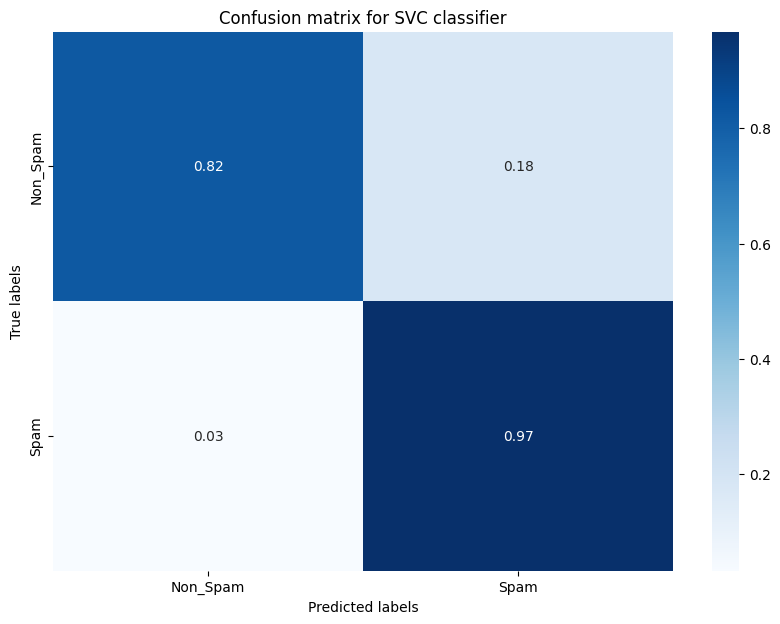

In [59]:
## LR Predictions on val set and confusion matrix
preds_svc = gs_svc.predict(val_X)
test['preds'] = preds_svc

# Generate confusion matrix
matrix_svc = confusion_matrix(test['Label'], test['preds'], normalize='true')

plt.figure(figsize=(10, 7))
sns.heatmap(matrix_svc, annot=True, fmt=".2f", cmap='Blues',xticklabels=['Non_Spam','Spam'], yticklabels=['Non_Spam','Spam'])

plt.title('Confusion matrix for SVC classifier')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Choose the best model based on score

In [60]:
# List with our trained models
models = []

models.append(gs_mnnb)
models.append(gs_lgrg)
models.append(gs_svc)

# Build a list of (score, model) tuples
scores = [(model.score(test_X, test_y), model) for model in models]

# Sort it on score
scores = sorted(scores, key=lambda x: x[0], reverse=True)

# Function to calculate and print additional metrics
def print_metrics(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, pos_label='Spam')
    recall = recall_score(y_true, y_pred, pos_label='Spam')
    f1 = f1_score(y_true, y_pred, pos_label='Spam')
    accuracy = accuracy_score(y_true, y_pred)

    print(f'The model {model_name} has reached {accuracy:.2f} accuracy on the test set')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    print()



# Print results for the three models
for score, model in scores:
    # Extract name of model from Pipeline
    if 'mnnb' in model.best_estimator_.named_steps:
        model_name = 'MultinomialNB'
    elif 'lgrg' in model.best_estimator_.named_steps:
        model_name = 'LogisticRegression'
    elif 'svc' in model.best_estimator_.named_steps:
        model_name = 'SVC'
    preds = model.predict(test_X)
    print_metrics(test_y, preds, model_name)


The model LogisticRegression has reached 0.96 accuracy on the test set
Precision: 0.94
Recall: 1.00
F1-Score: 0.97

The model SVC has reached 0.96 accuracy on the test set
Precision: 0.94
Recall: 1.00
F1-Score: 0.97

The model MultinomialNB has reached 0.92 accuracy on the test set
Precision: 0.88
Recall: 1.00
F1-Score: 0.94

